## 0.Librerías

In [1]:
import os
import pandas as pd
import time
import json

import numpy as np
from tqdm import tqdm
#from skimage.io import imread, imshow
#from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import cv2
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#%env SM_FRAMEWORK=tf.keras
# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, MaxPool2D
from tensorflow.keras.models import Model
#import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from tensorflow.keras import backend as tf_backend

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Cambia el directorio de trabajo a la carpeta deseada
os.chdir('/content/drive/MyDrive')
os.listdir()

Mounted at /content/drive


['Colab Notebooks',
 'buildings_png',
 'build_models',
 'roads_png',
 'road_models',
 'road_build_models',
 'build_models_custom',
 'Multiclass_img',
 'road_models_custom',
 'Add']

In [3]:
os.listdir('Multiclass_img')

['classes_corrected.json', 'Img', 'Notebooks', 'unet_architecture.py']

In [3]:
from Multiclass_img.unet_architecture import custom_Unet

In [4]:
data_path_images='Multiclass_img/Img'
data_list_direc = os.listdir(data_path_images)
tipo='images'
for direc in data_list_direc:
    data_path=data_path_images+'/'+direc+'/'+tipo
    data_list_images = os.listdir(data_path)
    for file in data_list_images:
        #img=cv2.imread('../Img/Tile 1/images/image_part_001.jpg')
        print(data_path+'/'+file)

Multiclass_img/Img/Tile 1/images/image_part_001.jpg
Multiclass_img/Img/Tile 1/images/image_part_002.jpg
Multiclass_img/Img/Tile 1/images/image_part_003.jpg
Multiclass_img/Img/Tile 1/images/image_part_004.jpg
Multiclass_img/Img/Tile 1/images/image_part_005.jpg
Multiclass_img/Img/Tile 1/images/image_part_006.jpg
Multiclass_img/Img/Tile 1/images/image_part_007.jpg
Multiclass_img/Img/Tile 1/images/image_part_008.jpg
Multiclass_img/Img/Tile 1/images/image_part_009.jpg
Multiclass_img/Img/Tile 2/images/image_part_001.jpg
Multiclass_img/Img/Tile 2/images/image_part_002.jpg
Multiclass_img/Img/Tile 2/images/image_part_003.jpg
Multiclass_img/Img/Tile 2/images/image_part_004.jpg
Multiclass_img/Img/Tile 2/images/image_part_005.jpg
Multiclass_img/Img/Tile 2/images/image_part_006.jpg
Multiclass_img/Img/Tile 2/images/image_part_007.jpg
Multiclass_img/Img/Tile 2/images/image_part_008.jpg
Multiclass_img/Img/Tile 2/images/image_part_009.jpg
Multiclass_img/Img/Tile 3/images/image_part_001.jpg
Multiclass_i

(644, 797, 3)


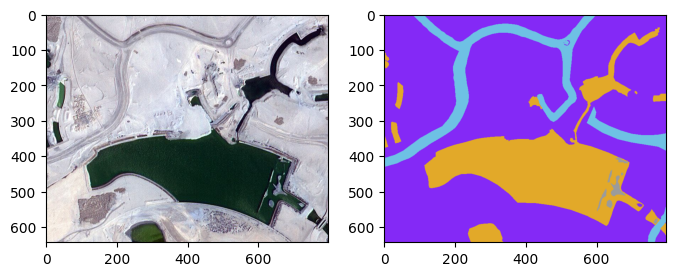

In [7]:
img=cv2.imread(data_path_images+'/Tile 1/images/image_part_002.jpg')
img_msk=cv2.imread(data_path_images+'/Tile 1/masks/image_part_002.png')

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_msk = cv2.cvtColor(img_msk, cv2.COLOR_BGR2RGB)
# Mostramos la imagen y su mascara asociada
print(rgb_img.shape)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.subplot(1,2,2)
plt.imshow(rgb_msk)
plt.show()


In [5]:

# Cargar el archivo JSON
with open("Multiclass_img/classes_corrected.json", "r") as archivo:
    datos_json = json.load(archivo)
def from_hex2rgb(hex_color):
    # Eliminar el carácter '#' si está presente
    hex_color = hex_color.lstrip('#')
    # Convertir cada par de caracteres hexadecimales en un valor RGB
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])
def from_rgb2bgr(color):
    return np.array([color[2],color[1],color[0]])
# Mostrar los datos cargados
dict_clases={}
i=0
for class_ in  datos_json['classes']:
    dict_clases[i]={'rgb':from_hex2rgb(class_['color']),'bgr':from_rgb2bgr(from_hex2rgb(class_['color'])),'name':class_['title'],'value':i}
    i+=1
for key in dict_clases:
    print(dict_clases[key]['name'],dict_clases[key]['rgb'],dict_clases[key]['bgr'],dict_clases[key]['value'])

Water [226 169  41] [ 41 169 226] 0
Land (unpaved area) [132  41 246] [246  41 132] 1
Road [110 193 228] [228 193 110] 2
Building [ 60  16 152] [152  16  60] 3
Vegetation [254 221  58] [ 58 221 254] 4
Unlabeled [155 155 155] [155 155 155] 5


In [6]:
def color_to_2D_label(msk,type_='bgr'):
    """
    FUNCION: 
        Pasar de mascara recien cargada a labels/clases
    PARAMS:
        msk: np.array de tamaño (y,x,3)
        type_: tipo de transformacion de bgr o rgb
    RETURN:
        label_seg: np.array de tamaño (y,x) de labels
    """
    label_seg = np.zeros(msk.shape,dtype=np.uint8)
    for i in dict_clases:
        label_seg [np.all(msk == dict_clases[i][type_],axis=-1)] = dict_clases[i]['value']

    label_seg = label_seg[:,:,0]

    return label_seg
def label_to_color(pred_mask,type_='bgr'):
    """
    FUNCION: 
        Pasar de mascaras con clase/label asignada a color
    PARAMS:
        pred_mask: np.array de tamaño (y,x)
        type_: tipo de transformacion a bgr o rgb
    RETURN:
        label_seg: np.array de tamaño (y,x,3) de colores
    """
    label_seg = np.zeros((pred_mask.shape[0],pred_mask.shape[0],3),dtype=np.uint8)
    for i in dict_clases:
        label_seg [np.where(pred_mask == dict_clases[i]['value'])] = dict_clases[i][type_]
    return label_seg

def open_imgs(file='../Img/Tile 1/images/image_part_002.jpg',resize_=False,data_path_images=data_path_images,resize_shape=(224,224)):
    """
    FUNCION: 
        cargar las img y sus msk, ademas, aplica un resize si se quiere
        
    PARAMS:
        file: directorio donde estan las img
        resize_: bool para indicar si se hace resiza
        data_path_images: directorio donde estan las img
        resize_shape: tupla (y,x) indicando el tamño del resize

    RETURN:
        resize_img,resize_msk: np.array de las img o msk
    """
    img=cv2.imread(file)
    tile=file.split('/')[2]
    name_img=file.split('/')[-1].replace('.jpg','')
    img_msk=cv2.imread(f'{data_path_images}/{tile}/masks/{name_img}.png')
    if resize_==True:
        resize_img=cv2.resize(img,resize_shape)
        resize_msk=cv2.resize(img_msk,resize_shape)
    else:
        resize_img,resize_msk=[img,img_msk]

    return resize_img,resize_msk
def search_dir(data_path_images=data_path_images):
    """
    FUNCION: 
        obtener directorios de las img
        
    PARAMS:
        data_path_images: directorio donde estan las img

    RETURN:
        dire_end: lista con directorios de las imagenes

    """
    tiles=os.listdir(data_path_images)
    dire_end=[]
    for tile in tiles:
        dire=os.listdir(f'{data_path_images}/{tile}/images/')
        dire=[f'{data_path_images}/{tile}/images/'+file for file in dire]
        dire_end+=dire
    return dire_end
def process_img(resize_=False,resize_shape=(224,224)):
    """
    FUNCION: 
        Procesar todas las imagenes en el directorio data_path_images
        
    PARAMS:
        resize_: bool para indicar si se hace resiza
        resize_shape: tupla (y,x) indicando el tamño del resize
    RETURN:
        labels,all_img: lista si resize_=False de np.arrays de las img o msk
                        np.array si resize_=True de tamaño (numero de imagenes,resize_shape,.) de las img o msk
    """
    #buscar paths
    filenames=search_dir()
    all_img=[]
    all_msk=[]
    ############# LOOP ABRIR/RESIZE IMG #################
    for file in tqdm(filenames):
        resize_img,resize_msk=open_imgs(file=file,resize_=resize_,resize_shape=resize_shape)
        all_img.append(resize_img)
        all_msk.append(resize_msk)
    if resize_==True:
        all_img=np.array(all_img)
        all_msk=np.array(all_msk)
    ############# LOOP TRANSFORM MASK TO LABELS ##############
    labels = []
    for mask in tqdm(all_msk):
        label = color_to_2D_label(mask,type_='bgr')
        labels.append(label)
    
    if resize_==True:
        labels = np.array(labels)
        print('Resize aplicado')
        print(labels.shape,all_img.shape)
    else:
        print(len(labels),len(all_img))

    return labels,all_img
labels,all_img=process_img(resize_=True,resize_shape=(224,224))

100%|██████████| 72/72 [00:00<00:00, 102.86it/s]

(72, 224, 224) (72, 224, 224, 3)


In [8]:
SMOOTH = 1e-5
def dice_multiv2(gt, pr, beta=1, num_classes=6, smooth=SMOOTH):
    """
    FUNCION: 
        Métrica de evaluacion coeficiente Dice (F1 score) para usar al entrenar modelos como metrica
    PARAMS:
        gt: Tensor ground truth (,y,x)
        pr: Tensor prediccion (,y,x,num_classes)
        beta: coeficiente para balancear precision y recall (beta=1 formula normal)
        num_classes: numero de clases a predecir
        smooth: numero para evitar divisiones por cero
    RETURN:
        Imagen y máscara recortadas.
    """


    # Convertir predicciones a clases discretas
    pr = tf_backend.argmax(pr, axis=-1)#pr(probabilidades)---> indice del mejor valor
    pr = tf_backend.one_hot(pr, num_classes=num_classes)#pr(indice del mejor valor)--->one hot
    gt = tf_backend.one_hot(tf_backend.cast(gt, tf.int32), num_classes=num_classes)
    # Convertir a float32 para evitar errores de tipo
    pr = tf_backend.cast(pr, tf.float32)
    gt = tf_backend.cast(gt, tf.float32)

    # Calcular intersección y unión (vectorizado)---> rapido
    intersection = tf_backend.sum(gt * pr, axis=[0, 1, 2])
    sum_gt = tf_backend.sum(gt, axis=[0, 1, 2])
    sum_pr = tf_backend.sum(pr, axis=[0, 1, 2])

    # Calcular TP, FP, FN
    tp = intersection #true positives
    fp = sum_pr - intersection# false positives
    fn = sum_gt - intersection# false negatives
    # F-beta score por clase (evitando divisiones por cero con smooth)
    fbeta_score_per_class = (1 + beta**2) * tp / ((1 + beta**2) * tp + beta**2 * fn + fp + smooth)

    # Promedio de todas las clases
    overall_score = tf_backend.mean(fbeta_score_per_class)
    return overall_score

In [14]:
unet_model=custom_Unet(shape=(224,224,3),classes=6,activation='softmax',filters=[32,64,128,256,512,256,128,64,32])
unet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[dice_multiv2,'accuracy'])
#unet_model.summary()

In [10]:

#labels,all_img
X_train, X_temp, y_train, y_temp = train_test_split(all_img, labels, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (50, 224, 224, 3)
Tamaño del conjunto de validación: (11, 224, 224, 3)
Tamaño del conjunto de prueba: (11, 224, 224, 3)


In [23]:
checkpoint = ModelCheckpoint(filepath='Multiclass_img/modelo_resize/modelo-{epoch:02d}-{val_accuracy:.2f}.weights.h5',
                             monitor='val_accuracy',   # chekeamos la val_acc
                             save_best_only=True,
                             save_weights_only=True,# Para guardar los pesos
                             mode='max',   # para coger la mejor acc
                             verbose=1)

In [24]:
start=time.time()
history=unet_model.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_val,y_val),
   callbacks=[checkpoint],
)
print(f'Finalizado en {round(time.time()-start,2)} s')

Epoch 1/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7146 - dice_multiv2: 0.4238 - loss: 0.7989
Epoch 1: val_accuracy improved from -inf to 0.64295, saving model to Multiclass_img/modelo_resize/modelo-01-0.64.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 0.7135 - dice_multiv2: 0.4186 - loss: 0.8049 - val_accuracy: 0.6430 - val_dice_multiv2: 0.4290 - val_loss: 0.9586
Epoch 2/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7014 - dice_multiv2: 0.4400 - loss: 0.8195
Epoch 2: val_accuracy improved from 0.64295 to 0.67691, saving model to Multiclass_img/modelo_resize/modelo-02-0.68.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 0.7072 - dice_multiv2: 0.4432 - loss: 0.8166 - val_accuracy: 0.6769 - val_dice_multiv2: 0.4897 - val_loss: 0.9316
Epoch 3/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7353 - dice_multiv2: 0.4662 - loss: 0.7749
Epoch 3: val_accuracy improved from 0.67691 to 0.68464, saving model to Multiclass_img/modelo_r

In [31]:
unet_model.save_weights('Multiclass_img/modelo_resize/model_final.weights.h5')

In [38]:
preds=unet_model.predict(X_test[:])
dice_test=dice_multiv2(y_test,preds)
print('DICE test:',dice_test.numpy(),' ACC',np.mean(np.argmax(preds, axis=-1)==y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
DICE test:  0.52871865  ACC 0.7803277916280148


In [28]:
import json

# Guardar el history en un archivo JSON
with open('history.json', 'w') as f:
    json.dump(history.history, f)

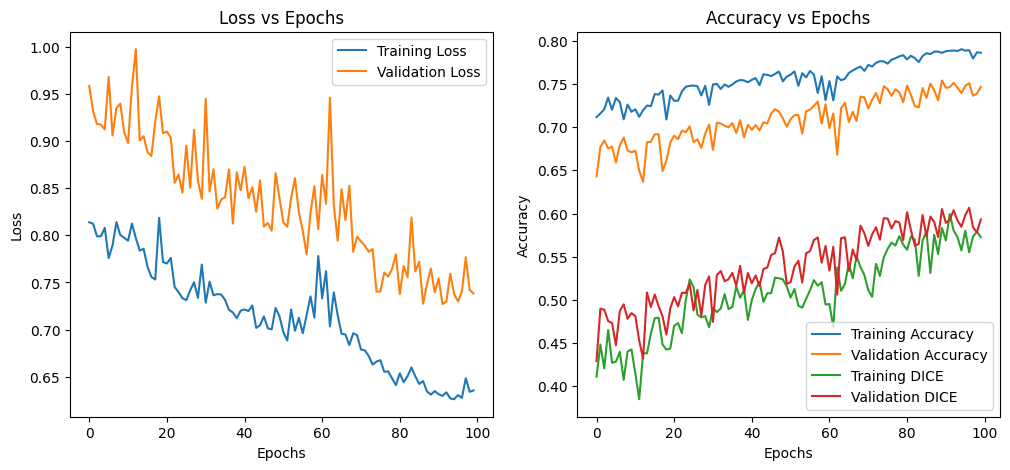

In [29]:
# Obtener los datos de 'loss' y 'accuracy' del objeto history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  # 'accuracy' es la métrica de precisión
val_accuracy = history.history.get('val_accuracy')  # Precisión en validación
dice=history.history.get('dice_multiv2')
val_dice=history.history.get('val_dice_multiv2')
# Crear el gráfico de Loss vs Epochs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(dice, label='Training DICE')
plt.plot(val_dice, label='Validation DICE')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar los gráficos
plt.show()

In [30]:
def plot_images_comparation(list_images_rows,titles_rows=["Input Image", "Real Mask", "Predicted Mask"]):
    num_rows = len(list_images_rows)
    fig=plt.figure(figsize=(15, 5*num_rows))
    index=1
    for i in range(num_rows):
        for j in range(3):
            plt.subplot(num_rows,3,index)
            plt.imshow(list_images_rows[i][j])
            plt.axis('off')
            if i==0:
                plt.title(titles_rows[j])
            index+=1
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
max_image=4
# Preparar imágenes y títulos para visualizar en grupos de tres
images_list = []
preds=unet_model.predict(X_train[:4])
#pred_binary = (preds > 0.5).astype(np.uint8)
preds_label = np.argmax(preds, axis=-1)
# Agrupar imágenes y títulos en filas de tres
for i in range(0, 4):
    input_image = X_train[i]
    ground_truth_mask = y_train[i]
    predicted_mask = preds_label[i]
    images_list.append([input_image, ground_truth_mask, predicted_mask])
plot_images_comparation(images_list)


Output hidden; open in https://colab.research.google.com to view.